<p>1. Consider that you are the head of your department and you want to determine each applicant’s chance of PhD admission based on their results on three exams (Written, Presentation, Viva). You have historical data from previous applicants that you can use as a training set. For each training example, you have the applicant’s scores on three exams and the admissions decision. Create the dataset.</p>

<p>(a) Use Logistic Regression to see the outputs.</p>


<p>(b) Use KNN to see the outputs. Perform K-NN selecting the best value of k and taking Euclidean distance as similarity measure.</p>


<p>(c) Use different metrics to check the performance of both the classifiers. Interpret the
results.</p>


<b>used dataset link [phd_admission_dataset.csv]  (https://drive.google.com/file/d/12Gw_HZ1faZ0DLiRHLqh2xfHqPKFsNTFe/view?usp=sharing).

### Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [2]:
url = 'https://drive.google.com/file/d/12Gw_HZ1faZ0DLiRHLqh2xfHqPKFsNTFe/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data=pd.read_csv(path)
data.head()

,written,presentation,viva,admission_chance
0,148,72,50,1
1,85,66,31,0
2,183,64,32,1
3,89,66,21,0
4,137,40,33,1


In [3]:
# 0 defines no
# 1 defines yes

data['admission_chance'].value_counts()

0    500
1    268
Name: admission_chance, dtype: int64

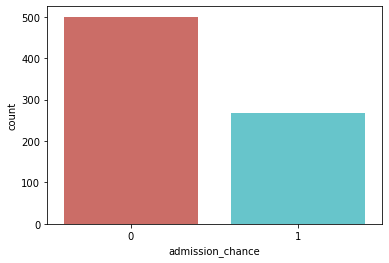

In [4]:
sns.countplot(x='admission_chance', data=data, palette='hls' )
plt.show()

### Segregating variables: Independent and Dependent Variables

In [5]:
X = data.drop('admission_chance', axis = 1)
y = data['admission_chance']

### Splitting the data into train set, cross validation set and the test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48, stratify=y)

In [7]:
print("train data:", X_train.shape, y_train.shape)
print("test data: ", X_test.shape, y_test.shape)

train data: (614, 3) (614,)
test data:  (154, 3) (154,)


### (a) Use Logistic Regression

In [8]:
clf = LogisticRegression(penalty='l2', random_state=15)
clf.fit(X_train, y_train)

LogisticRegression(random_state=15)

In [9]:
train_pred = clf.predict(X_train)
train_f1 = f1_score(y_train, train_pred)
print("train f1_score ", train_f1)

train f1_score  0.586021505376344


In [10]:
test_pred = clf.predict(X_test)
test_f1 = f1_score(y_test, test_pred)
print("test f1_score ", test_f1)

test f1_score  0.553191489361702


### Hyperparameter tuning for Logistic regression (C)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
best C for given dataset 0.1
tested hyperparameter [0.001 0.05 0.01 0.1 0.5 1 5 10 50]


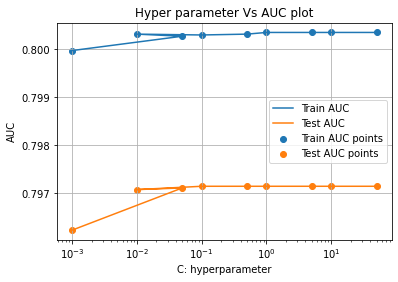

In [13]:
lr=LogisticRegression(penalty='l2', random_state=15)
param_grid= {"C": [0.001,0.05,0.01,0.1,0.5,1,5,10,50]}


clf=GridSearchCV(lr, param_grid, cv=3, scoring='roc_auc', verbose=1, return_train_score=True)
clf.fit(X_train, y_train)
#print("best C for given dataset",clf.best_params_)
best_C=clf.best_params_['C']
print("best C for given dataset",best_C)
train_auc=clf.cv_results_['mean_train_score']
train_auc_std=clf.cv_results_['std_train_score']
cv_auc=clf.cv_results_['mean_test_score'] 
cv_auc_std=clf.cv_results_['std_test_score']

C =  clf.cv_results_['param_C']
print("tested hyperparameter",C)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

plt.semilogx(C, train_auc, label='Train AUC')

plt.semilogx(C, cv_auc, label='Test AUC')

plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='Test AUC points')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#results.head(5)

In [12]:
# retraining model using best hyperparameter

clf = LogisticRegression(penalty='l2', random_state=15, C=best_C)
clf.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=15)

In [13]:
# f1_score for test data

test_pred = clf.predict(X_test)
test_f1 = f1_score(y_test, test_pred)
print("test f1_score ", test_f1)

test f1_score  0.553191489361702


####  Testing the performance of the model on test data, plotting ROC Curves

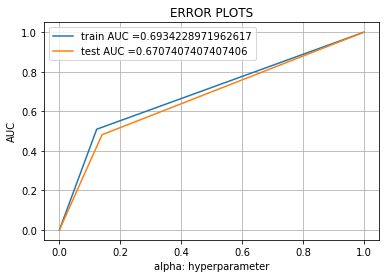

In [14]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
            
lr = LogisticRegression(penalty='l2', random_state=15, C=best_C)
lr.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_logistic = auc(test_fpr, test_tpr)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
#print(auc_logistic)

In [15]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.44695093457943924 for threshold 1


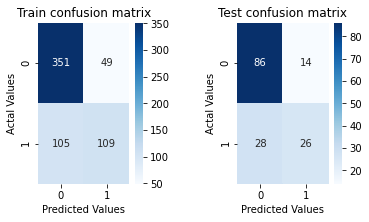

In [16]:
#print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

plt.subplot(1, 2, 1) # row 1, col 2 index 1
#print("Train confusion matrix")
cm_train_bow = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(cm_train_bow, annot=True,fmt="d",cmap='Blues')
plt.title("Train confusion matrix")
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

plt.subplot(1, 2, 2) # index 2
#print("Test confusion matrix")
cm_test_bow = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(cm_test_bow, annot=True,fmt="d",cmap='Blues')
plt.title("Test confusion matrix")
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

plt.tight_layout(4)
plt.show()

### (b) Use KNN

In [17]:
clf = KNeighborsClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [18]:
train_pred = clf.predict(X_train)
train_f1 = f1_score(y_train, train_pred)
print("train f1_score ", train_f1)

train f1_score  0.7360774818401936


In [19]:
test_pred = clf.predict(X_test)
test_f1 = f1_score(y_test, test_pred)
print("test f1_score ", test_f1)

test f1_score  0.6153846153846153


### Hyperparameter tuning for KNeighborsClassifier (K)

Fitting 3 folds for each of 34 candidates, totalling 102 fits
best K for given dataset 27
tested hyperparameter  [3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49 51 53
 55 57 59 61 63 65 67 69]


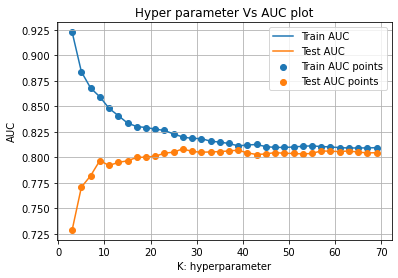

In [20]:
knn=KNeighborsClassifier()
param_grid= {"n_neighbors": np.arange(3,70,2)}


clf=GridSearchCV(knn, param_grid, cv=3, scoring='roc_auc', verbose=1, return_train_score=True)
clf.fit(X_train, y_train)
#print("best C for given dataset",clf.best_params_)
best_K=clf.best_params_['n_neighbors']
print("best K for given dataset",best_K)
train_auc=clf.cv_results_['mean_train_score']
train_auc_std=clf.cv_results_['std_train_score']
cv_auc=clf.cv_results_['mean_test_score'] 
cv_auc_std=clf.cv_results_['std_test_score']

K =  clf.cv_results_['param_n_neighbors']
print("tested hyperparameter ",K)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='Test AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='Test AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#results.head(5)

In [21]:
# retraining model using best hyperparameter

clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=best_K)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=27)

In [22]:
# f1_score for test data

test_pred = clf.predict(X_test)
test_f1 = f1_score(y_test, test_pred)
print("test f1_score ", test_f1)

test f1_score  0.606060606060606


####  Testing the performance of the model on test data, plotting ROC Curves

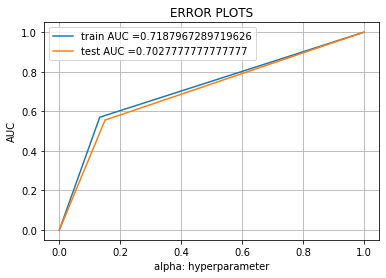

In [23]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
            
lr = KNeighborsClassifier(n_jobs=-1, n_neighbors=best_K)
lr.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_knn = auc(test_fpr, test_tpr)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
#print(auc_knn)

the maximum value of tpr*(1-fpr) 0.49455607476635505 for threshold 1


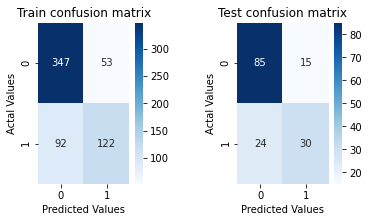

In [24]:
#print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

plt.subplot(1, 2, 1) # row 1, col 2 index 1
#print("Train confusion matrix")
cm_train_bow = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(cm_train_bow, annot=True,fmt="d",cmap='Blues')
plt.title("Train confusion matrix")
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

plt.subplot(1, 2, 2) # index 2
#print("Test confusion matrix")
cm_test_bow = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(cm_test_bow, annot=True,fmt="d",cmap='Blues')
plt.title("Test confusion matrix")
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

plt.tight_layout(4)
plt.show()

## Summary

In [25]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Hyperparameter", "AUC"]

x.add_row(["LogisticRegression", best_C, auc_logistic])
x.add_row(["KNeighborsClassifier", best_K, auc_knn])
print(x)

+----------------------+----------------+--------------------+
|        Model         | Hyperparameter |        AUC         |
+----------------------+----------------+--------------------+
|  LogisticRegression  |      0.1       | 0.6707407407407406 |
| KNeighborsClassifier |       27       | 0.7027777777777777 |
+----------------------+----------------+--------------------+
